In [94]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

In [115]:
import  numpy as np
import xarray as xr
import random
import tqdm
import matplotlib.pyplot as plt
import pandas as pd
# import sub_function.sub_toolbox as tb
from sub_function.sub_toolbox import*
import SOM_sub as SOM

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.mpl.ticker as cticker
import cartopy.io.shapereader as shpreader
import sys

In [11]:
import importlib
! jupyter nbconvert --to python sub_function/sub_toolbox.ipynb
# ! jupyter nbconvert --to python SOM_sub.ipynb
# importlib.reload(tb)
# importlib.reload(SOM)
# importlib.reload(sub_toolbox)
# importlib.import_module('*','sub_function')

[NbConvertApp] Converting notebook sub_function/sub_toolbox.ipynb to python
[NbConvertApp] Writing 1476 bytes to sub_function/sub_toolbox.py


In [242]:
type = xr.DataArray(5)
type.attrs['year'] = np.arange(1979,2018+1)
type.attrs['level'] = 850
type.attrs['months'] = [7,8]
ranges = [-20,60,100,160]
# import sub_function.sub_toolbox as tb
# var = tb.read_ERA5(type,ranges,True)
# from sub_function.sub_toolbox import *
var = read_jra55(type,ranges,True)*1000000
# var.loc[1998,:,10,110]
var_JA = var.mean(dim = 'month')
var_JA_clim = var_JA.mean(dim = 'year')
var_JA_ano = var_JA - var_JA_clim

ano_re = var_JA_ano.stack(spatial = ('lat','lon'))
# var_JA_ano
N,D = np.shape(ano_re) #查看数组大小
# print(N,D)

In [221]:
def weights_PCA(X,Y,data):
    
    N,D = np.shape(data)
    weights = np.zeros([X,Y,D])
    
    pc_length, pc = np.linalg.eig(np.cov(np.transpose(data)))
    pc_order = np.argsort(-pc_length)
    for i, c1 in enumerate(np.linspace(-1, 1, X)):
        for j, c2 in enumerate(np.linspace(-1, 1, Y)):
            weights[i, j] = c1*pc[pc_order[0]] + c2*pc[pc_order[1]]
    return weights

In [244]:

datas = ano_re.values
# 对训练数据进行正则化处理
datas = SOM.feature_normalization(datas)
# datas = var_std
# # SOM的训练
X = 4
Y = 1
weights = SOM.train(X=X,Y=Y,N_epoch=2000,datas=datas,sigma=1.5,init_weight_fun=None)



Epoch 1
quantization_error= 58.3221
Epoch 2
quantization_error= 58.3611
Epoch 3
quantization_error= 58.1008
Epoch 4
quantization_error= 58.8174
Epoch 5
quantization_error= 58.9349
Epoch 6
quantization_error= 57.9662
Epoch 7
quantization_error= 59.5465
Epoch 8
quantization_error= 58.7787
Epoch 9
quantization_error= 57.9953
Epoch 10
quantization_error= 57.6827
Epoch 11
quantization_error= 60.3102
Epoch 12
quantization_error= 58.5657
Epoch 13
quantization_error= 59.6774
Epoch 14
quantization_error= 59.2862
Epoch 15
quantization_error= 58.1328
Epoch 16
quantization_error= 58.4165
Epoch 17
quantization_error= 58.6875
Epoch 18
quantization_error= 58.9844
Epoch 19
quantization_error= 58.0741
Epoch 20
quantization_error= 58.2063
Epoch 21
quantization_error= 59.9016
Epoch 22
quantization_error= 58.3341
Epoch 23
quantization_error= 58.4813
Epoch 24
quantization_error= 56.8361
Epoch 25
quantization_error= 57.5119
Epoch 26
quantization_error= 59.3624
Epoch 27
quantization_error= 58.8196
Epoch 28
q

<Figure size 648x648 with 0 Axes>

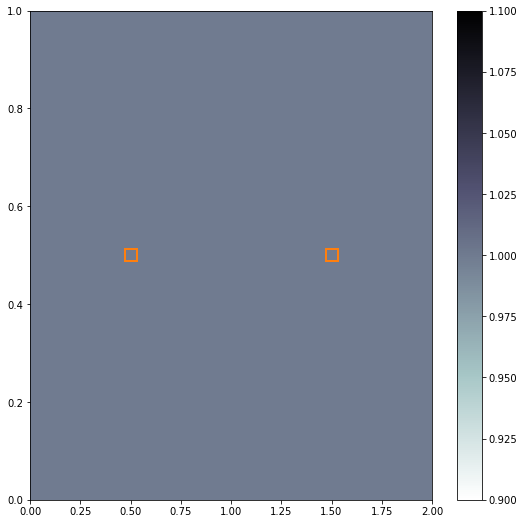

In [122]:
# # 获取UMAP
UM = SOM.get_U_Matrix(weights)

plt.figure(figsize=(9, 9))
plt.pcolor(UM.T, cmap='bone_r')  # plotting the distance map as background
plt.colorbar()

markers = ['o', 's', 'D']
colors = ['C0', 'C1', 'C2']

for i in range(N):#N表示有几年，也就是有几个样本
    
    x = datas[i]
    w = SOM.get_winner_index(x,weights)
    i_lab = 1#labs[i]-1
    
    plt.plot(w[0]+.5, w[1]+.5, markers[i_lab], markerfacecolor='None',
         markeredgecolor=colors[i_lab], markersize=12, markeredgewidth=2)

plt.show()

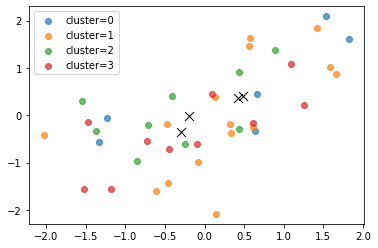

In [245]:
# 实现聚类

# 获取聚类的编号
index_clusters = []
for i in range(N):
    x = datas[i]
    winner = SOM.get_winner_index(x,weights)
    index_clusters.append(winner[0]*Y+winner[1])
# index_clusters

for c in np.unique(index_clusters):
    
    ii = np.where(index_clusters==c)[0]
    
    plt.scatter(datas[ii, 0],
                datas[ii, 2], label='cluster='+str(c), alpha=.7)
plt.legend()                
for i in range(X):
    for j in range(Y):
        plt.scatter(weights[i,j,0], weights[i,j,2], marker='x', 
            s=80, linewidths=1, color='k')
plt.legend()
plt.show()

In [246]:
# var_JA
# index_clusters
index_clusters = np.array(index_clusters)
# index_clusters
# a = index_clusters.index(1)
condition = index_clusters == 0
year0 = np.extract(condition, type.year)
condition = index_clusters == 1
year1 = np.extract(condition, type.year)
condition = index_clusters == 2
year2 = np.extract(condition, type.year)
condition = index_clusters == 3
year3 = np.extract(condition, type.year)
var0 = var_JA_ano.loc[year0,:,:]
var_mean0 = var0.mean(dim = 'year')

var1 = var_JA_ano.loc[year1,:,:]
var_mean1 = var1.mean(dim = 'year')

var2 = var_JA_ano.loc[year2,:,:]
var_mean2 = var2.mean(dim = 'year')

var3 = var_JA_ano.loc[year3,:,:]
var_mean3 = var3.mean(dim = 'year')
year0
year1
year2
year3
# var_mean2 = var2.sum

array([1981, 1984, 1985, 1986, 1989, 1990])

array([1994, 1997, 1999, 2000, 2001, 2002, 2004, 2005, 2006, 2009, 2011,
       2012, 2014, 2015, 2018])

array([1979, 1980, 1982, 1983, 1987, 1991, 1992, 1993, 2003])

array([1988, 1995, 1996, 1998, 2007, 2008, 2010, 2013, 2016, 2017])

In [225]:
# from sub_function import sub_toolbox
# importlib.reload(sub_toolbox)
# # np.arange(1979,2018+1)
# sub_toolbox.ispan(1979,2018)

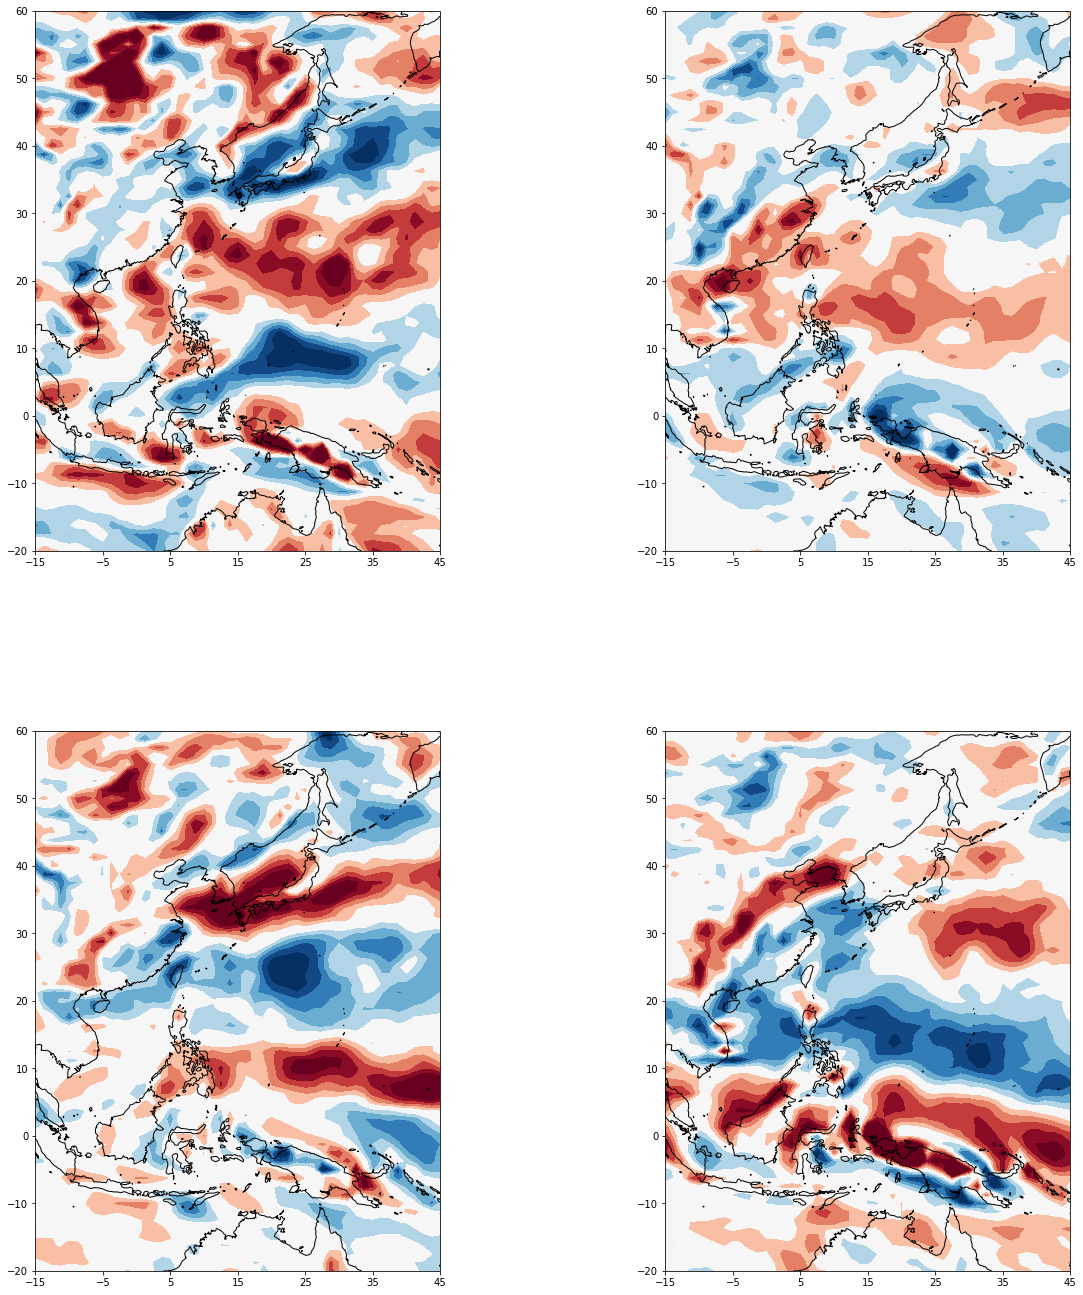

In [247]:
var = var_mean0
fig = plt.figure(figsize=(25,25))
proj = ccrs.PlateCarree(central_longitude=115) 
#设置一个圆柱投影坐标，中心经度115°E
lowerlat, upperlat,leftlon,rightlon = (-20,60,100,160)
cnLevels = np.array([-5.,-4,-3,-2,-1,1,2,3,4,5]) * 1.
# leftlon, rightlon, lowerlat, upperlat = (-180,180,-30,90)
#设置地图边界范围

f1_ax1 = fig.add_axes([0.1, 0.8, 0.3, 0.3],projection = proj)
f1_ax1.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
f1_ax1.add_feature(cfeature.COASTLINE.with_scale('50m'))
# f2_ax1.add_feature(cfeature.LAKES, alpha=0.5)
f1_ax1.set_xticks(np.arange(leftlon,rightlon+10,10), crs=ccrs.PlateCarree())
f1_ax1.set_yticks(np.arange(lowerlat,upperlat+10,10), crs=ccrs.PlateCarree())
# lon_formatter = cticker.LongitudeFormatter()
# lat_formatter = cticker.LatitudeFormatter()
# f2_ax1.xaxis.set_major_formatter(lon_formatter)
# f2_ax1.yaxis.set_major_formatter(lat_formatter)
# f2_ax1.set_title('(a)',loc='left',fontsize =15)
#f2_ax1.set_title( '%.2f%%' % (var[0]*100),loc='right',fontsize =15)
X,Y = np.meshgrid(var.lon,var.lat)
f1_ax1.contourf(X,Y, var, levels=cnLevels, zorder=0, extend = 'both',transform=ccrs.PlateCarree(), cmap=plt.cm.RdBu_r)

var = var_mean1
f2_ax1 = fig.add_axes([0.35, 0.8, 0.5, 0.3],projection = proj)
f2_ax1.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
f2_ax1.add_feature(cfeature.COASTLINE.with_scale('50m'))
# f2_ax1.add_feature(cfeature.LAKES, alpha=0.5)
f2_ax1.set_xticks(np.arange(leftlon,rightlon+10,10), crs=ccrs.PlateCarree())
f2_ax1.set_yticks(np.arange(lowerlat,upperlat+10,10), crs=ccrs.PlateCarree())
# lon_formatter = cticker.LongitudeFormatter()
# lat_formatter = cticker.LatitudeFormatter()
# f2_ax1.xaxis.set_major_formatter(lon_formatter)
# f2_ax1.yaxis.set_major_formatter(lat_formatter)
# f2_ax1.set_title('(a)',loc='left',fontsize =15)
#f2_ax1.set_title( '%.2f%%' % (var[0]*100),loc='right',fontsize =15)
X,Y = np.meshgrid(var.lon,var.lat)
f2_ax1.contourf(X,Y, var, levels=cnLevels, zorder=0, extend = 'both',transform=ccrs.PlateCarree(), cmap=plt.cm.RdBu_r)
#china = shpreader.Reader('bou2_4l.dbf').geometries()
#f2_ax1.add_geometries(china, ccrs.PlateCarree(),facecolor='none', edgecolor='black',zorder = 1)

var = var_mean2
f3_ax1 = fig.add_axes([0.1, 0.4, 0.3, 0.3],projection = proj)
f3_ax1.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
f3_ax1.add_feature(cfeature.COASTLINE.with_scale('50m'))
# f3_ax1.add_feature(cfeature.LAKES, alpha=0.5)
f3_ax1.set_xticks(np.arange(leftlon,rightlon+10,10), crs=ccrs.PlateCarree())
f3_ax1.set_yticks(np.arange(lowerlat,upperlat+10,10), crs=ccrs.PlateCarree())
# lon_formatter = cticker.LongitudeFormatter()
# lat_formatter = cticker.LatitudeFormatter()
# f3_ax1.xaxis.set_major_formatter(lon_formatter)
# f3_ax1.yaxis.set_major_formatter(lat_formatter)
# f3_ax1.set_title('(a)',loc='left',fontsize =15)
#f3_ax1.set_title( '%.2f%%' % (var[0]*100),loc='right',fontsize =15)
X,Y = np.meshgrid(var.lon,var.lat)
f3_ax1.contourf(X,Y, var, levels=cnLevels, zorder=0, extend = 'both',transform=ccrs.PlateCarree(), cmap=plt.cm.RdBu_r)
#china = shpreader.Reader('bou2_4l.dbf').geometries()
#f3_ax1.add_geometries(china, ccrs.PlateCarree(),facecolor='none', edgecolor='black',zorder = 1)

var = var_mean3
f4_ax1 = fig.add_axes([0.35, 0.4, 0.5, 0.3],projection = proj)
f4_ax1.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
f4_ax1.add_feature(cfeature.COASTLINE.with_scale('50m'))
# f4_ax1.add_feature(cfeature.LAKES, alpha=0.5)
f4_ax1.set_xticks(np.arange(leftlon,rightlon+10,10), crs=ccrs.PlateCarree())
f4_ax1.set_yticks(np.arange(lowerlat,upperlat+10,10), crs=ccrs.PlateCarree())
# lon_formatter = cticker.LongitudeFormatter()
# lat_formatter = cticker.LatitudeFormatter()
# f4_ax1.xaxis.set_major_formatter(lon_formatter)
# f4_ax1.yaxis.set_major_formatter(lat_formatter)
# f4_ax1.set_title('(a)',loc='left',fontsize =15)
#f4_ax1.set_title( '%.2f%%' % (var[0]*100),loc='right',fontsize =15)
X,Y = np.meshgrid(var.lon,var.lat)
f4_ax1.contourf(X,Y, var, levels=cnLevels, zorder=0, extend = 'both',transform=ccrs.PlateCarree(), cmap=plt.cm.RdBu_r)
#china = shpreader.Reader('bou2_4l.dbf').geometries()
#f4_ax1.add_geometries(china, ccrs.PlateCarree(),facecolor='none', edgecolor='black',zorder = 1)
plt.show()